# MOVIE_DATA_ANALYSIS🎥🎬🎞️🍿

## 과제 🔥🔥
### 영화 평점과 흥행 수익 간의 상관관계 분석 

#### 사용자 평점, 비평가 평점, 박스오피스 수익 간의 관계를 분석하고, 평점이 높지만 흥행하지 못한 영화와 평점은 낮지만 흥행한 영화들의 특성을 비교 분석하세요.

#### **한국 박스오피스 수익 연결**
- API 키 발급 받아서 본래 갖고 있던 csv DF 에다가 영화 제목에 맞춰서 병합하려 했으나 실패 ! ㅜ

In [1]:
import pandas as pd
import requests
import time
from datetime import datetime, timedelta
import difflib
import os

# 환경 변수에서 KOFIC API 키를 불러옵니다.
# Loads the KOFIC API key from the environment variable.
KOFIC_API_KEY = os.getenv("KOFIC_API_KEY")

if not KOFIC_API_KEY:
    print("Error: The environment variable 'KOFIC_API_KEY' was not found.")
    print("Please make sure you have set the environment variable correctly.")
    # Stop execution if the API key is not found.
    # API 키를 찾지 못하면 실행을 중단합니다.
    exit()

# Load the TMDB data
try:
    df = pd.read_csv('tmdb_kr_theatrical_2005_2025.csv')
except FileNotFoundError:
    print("Error: The file 'tmdb_kr_theatrical_2005_2025.csv' was not found.")
    df = pd.DataFrame()

if not df.empty:
    # Prepare the DataFrame for new data
    df['kofic_movie_code'] = None
    df['kofic_gross_sales'] = 0
    df['kofic_total_audience'] = 0

    # Convert release_date to a proper date object for comparison
    df['release_date'] = pd.to_datetime(df['release_date'])

    def find_kofic_movie_code(title, release_date):
        """
        Finds the KOFIC movie code using a robust multi-stage matching logic.
        
        Args:
            title (str): The title of the movie from TMDB.
            release_date (datetime): The release date of the movie.
            
        Returns:
            str: The KOFIC movie code if a suitable match is found, otherwise None.
        """
        release_year = release_date.year
        search_url = f"http://www.kobis.or.kr/kobisopenapi/webservice/rest/movie/searchMovieList.json?key={KOFIC_API_KEY}&movieNm={title}&openStartDt={release_year}"

        try:
            response = requests.get(search_url)
            # Check for specific HTTP errors
            if response.status_code == 401:
                print("API Error: 401 Unauthorized. Please check if your KOFIC API key is correct.")
                return None
            elif response.status_code == 429:
                print("API Error: 429 Too Many Requests. You may have exceeded the daily limit. Please try again later.")
                return None
            response.raise_for_status()
            data = response.json()
        except requests.exceptions.RequestException as e:
            print(f"Error fetching KOFIC data for {title}: {e}")
            return None

        if 'movieListResult' not in data or not data['movieListResult']['movieList']:
            print(f"  > No search results found for '{title}'.")
            return None

        movie_list = data['movieListResult']['movieList']
        
        best_match_code = None
        highest_score = 0
        min_date_diff = timedelta(days=9999)

        for movie in movie_list:
            kofic_title = movie.get('movieNm', '')
            kofic_release_date_str = movie.get('openDt', '')
            
            if not kofic_title or not kofic_release_date_str:
                continue

            # Calculate fuzzy similarity score
            score = difflib.SequenceMatcher(None, title, kofic_title).ratio()

            # Convert KOFIC date string to a datetime object
            try:
                kofic_release_date = datetime.strptime(kofic_release_date_str, '%Y%m%d')
            except ValueError:
                continue
                
            date_diff = abs((kofic_release_date - release_date).days)
            
            # Stage 1: Check for perfect title match and reasonable date difference
            if score == 1.0 and date_diff < 14:
                print(f"  > Perfect title match found with date diff of {date_diff} days.")
                return movie['movieCd']

            # Stage 2: Look for the best fuzzy match
            if score > highest_score and date_diff < 365: # Allow a year diff for flexible matching
                highest_score = score
                min_date_diff = date_diff
                best_match_code = movie['movieCd']
        
        # Final check: return the best fuzzy match if the score is high enough
        if best_match_code and highest_score >= 0.80: # Now using a more flexible 80% threshold
            print(f"  > Found a fuzzy match with score {highest_score:.2f} and date diff {min_date_diff} days.")
            return best_match_code
        
        print(f"  > No suitable match found for '{title}'. Best score was {highest_score:.2f}.")
        return None

    def get_kofic_data(movie_code):
        """
        Fetches the total gross sales and audience from KOFIC using the movie code.
        This uses the searchMovieInfo API, which provides cumulative data.
        
        Args:
            movie_code (str): The KOFIC movie code.
            
        Returns:
            tuple: A tuple containing (gross_sales, total_audience) or (0, 0) if not found.
        """
        info_url = f"http://www.kobis.or.kr/kobisopenapi/webservice/rest/movie/searchMovieInfo.json?key={KOFIC_API_KEY}&movieCd={movie_code}"
        
        try:
            response = requests.get(info_url)
            # Check for specific HTTP errors
            if response.status_code == 401:
                print("API Error: 401 Unauthorized. Please check if your KOFIC API key is correct.")
                return 0, 0
            elif response.status_code == 429:
                print("API Error: 429 Too Many Requests. You may have exceeded the daily limit. Please try again later.")
                return 0, 0
            response.raise_for_status()
            data = response.json()
        except requests.exceptions.RequestException as e:
            print(f"Error fetching KOFIC info for {movie_code}: {e}")
            return 0, 0

        if 'movieInfoResult' in data:
            movie_info = data['movieInfoResult']['movieInfo']
            
            # Extract sales and audience data
            sales = int(movie_info.get('salesAcc', '0'))
            audience = int(movie_info.get('audiAcc', '0'))
            return sales, audience
        
        return 0, 0

    # Main loop to process the DataFrame
    print("Starting data processing...")
    for index, row in df.iterrows():
        title = row['title']
        release_date = row['release_date']

        # Skip rows with no title or date
        if pd.isna(title) or pd.isna(release_date):
            continue

        print(f"Processing '{title}' released on {release_date.strftime('%Y-%m-%d')}...")
        
        # Find the KOFIC movie code
        movie_code = find_kofic_movie_code(title, release_date)

        if movie_code:
            df.at[index, 'kofic_movie_code'] = movie_code
            
            # Get the cumulative sales and audience using the improved function
            gross_sales, total_audience = get_kofic_data(movie_code)
            
            if gross_sales > 0:
                df.at[index, 'kofic_gross_sales'] = gross_sales
                df.at[index, 'kofic_total_audience'] = total_audience
                print(f"  > Gross Sales: {gross_sales}, Total Audience: {total_audience}")
            else:
                print("  > No box office data found from movie info.")
        else:
            print(f"  > No suitable KOFIC movie code found.")

        # Add a short delay to avoid overwhelming the API
        time.sleep(0.5)

    print("\nProcessing complete. Displaying a sample of the updated DataFrame:")
    print(df[['title', 'release_date', 'kofic_gross_sales', 'kofic_total_audience']].head())

    # Save the updated DataFrame to a new CSV file
    df.to_csv('tmdb_kofic_combined.csv', index=False, encoding='utf-8-sig')
    print("\nUpdated DataFrame saved to 'tmdb_kofic_combined.csv'")


Starting data processing...
Processing '올드보이' released on 2003-11-21...
  > Perfect title match found with date diff of 0 days.
  > No box office data found from movie info.
Processing '괴물' released on 2006-07-27...
  > Perfect title match found with date diff of 0 days.
  > No box office data found from movie info.
Processing '활' released on 2005-05-12...
  > No suitable match found for '활'. Best score was 0.00.
  > No suitable KOFIC movie code found.
Processing '밀양' released on 2007-05-23...
Error fetching KOFIC data for 밀양: 503 Server Error: Service Unavailable for url: http://www.kobis.or.kr/kobisopenapi/webservice/rest/movie/searchMovieList.json?key=a3c5aea7d99b9dca621b49723c85b8e3&movieNm=%EB%B0%80%EC%96%91&openStartDt=2007
  > No suitable KOFIC movie code found.
Processing '친절한 금자씨' released on 2005-07-29...
  > Perfect title match found with date diff of 0 days.
  > No box office data found from movie info.
Processing '싸이보그지만 괜찮아' released on 2006-12-07...
  > Perfect title mat

KeyboardInterrupt: 

#### **평점이 높은 영화들 중 수익이 낮은 영화**

>>> TMDB 영화 데이터 분석을 시작합니다.
'tmdb_kr_theatrical_2005_2025.csv' 파일을 성공적으로 불러왔습니다. 총 4662개의 영화 데이터가 있습니다.
분석을 위해 수익이 있고 투표 수가 10개 이상인 258개의 영화를 필터링했습니다.

>>> 사용자 평점과 흥행 수익 간의 상관계수: 0.2378


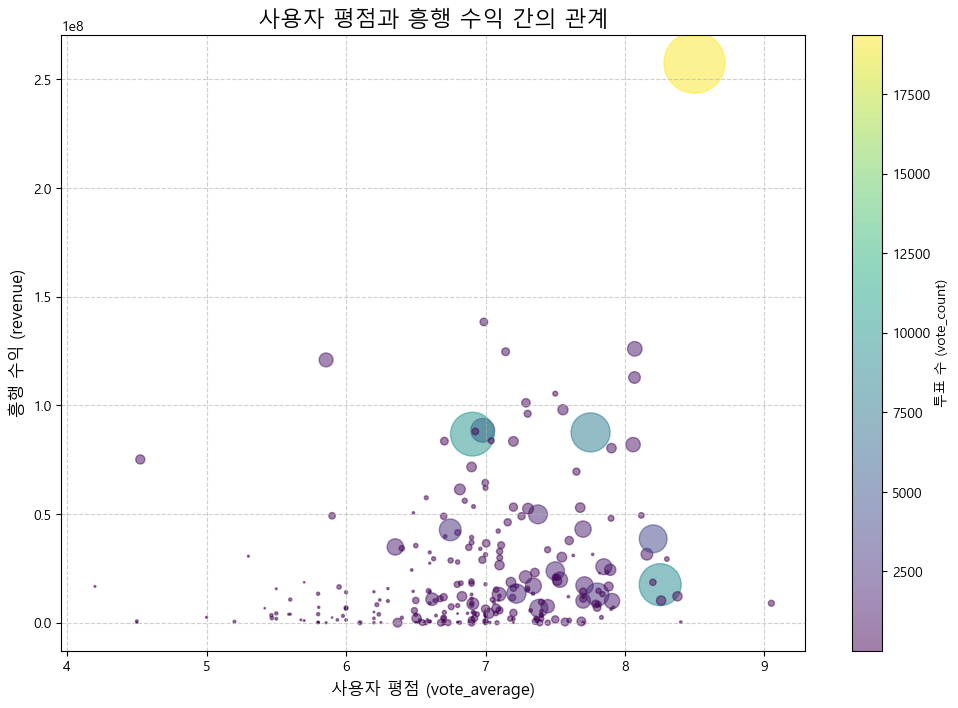


>>> 평점은 높지만 흥행 수익이 낮은 영화 (상위 5개)


,title,vote_average,revenue,vote_count
2948,브레이크 더 사일런스: 더 무비,9.049,8954945,184
1939,기생충,8.498,257591776,19364
4381,"그 시절, 우리가 좋아했던 소녀",8.400,302086,32
2447,브링 더 소울: 더 무비,8.376,12150259,444
3896,방탄소년단: 옛 투 컴 인 시네마,8.300,29291883,107



>>> 흥행 수익은 높지만 평점이 낮은 영화 (상위 5개)


,title,vote_average,revenue,vote_count
1939,기생충,8.498,257591776,19364
876,명량,6.988,138342258,300
1326,신과함께-죄와 벌,8.070,125983972,1099
2203,극한직업,7.144,124652206,316
718,넛잡: 땅콩 도둑들,5.857,120885527,1000


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# matplotlib에서 한글 폰트가 깨지는 문제를 해결합니다.
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print(">>> TMDB 영화 데이터 분석을 시작합니다.")

# 1. 파일 불러오기
file_path = 'tmdb_kr_theatrical_2005_2025.csv'
try:
    df = pd.read_csv(file_path)
    print(f"'{file_path}' 파일을 성공적으로 불러왔습니다. 총 {len(df)}개의 영화 데이터가 있습니다.")
except FileNotFoundError:
    print(f"오류: '{file_path}' 파일을 찾을 수 없습니다. 파일 경로를 확인해 주세요.")
    exit()

# 2. 데이터 정제 및 필터링
# 분석의 정확성을 위해 수익이 0이거나 투표 수가 10개 미만인 영화는 제외합니다.
df_filtered = df[(df['revenue'] > 0) & (df['vote_count'] >= 10)].copy()
print(f"분석을 위해 수익이 있고 투표 수가 10개 이상인 {len(df_filtered)}개의 영화를 필터링했습니다.")

# 3. 상관관계 계산
# 사용자 평점(vote_average)과 흥행 수익(revenue) 간의 상관계수를 계산합니다.
correlation = df_filtered['vote_average'].corr(df_filtered['revenue'])
print(f"\n>>> 사용자 평점과 흥행 수익 간의 상관계수: {correlation:.4f}")

# 4. 데이터 시각화
plt.figure(figsize=(12, 8))
plt.scatter(df_filtered['vote_average'], df_filtered['revenue'], alpha=0.5, c=df_filtered['vote_count'], cmap='viridis', s=df_filtered['vote_count']/10)
plt.title('사용자 평점과 흥행 수익 간의 관계', fontsize=16)
plt.xlabel('사용자 평점 (vote_average)', fontsize=12)
plt.ylabel('흥행 수익 (revenue)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.colorbar(label='투표 수 (vote_count)')
plt.show()

# 5. 특이 사례 분석
# 흥행 수익이 낮지만 평점이 높은 영화를 찾습니다 (비교적 적은 투표 수일 수 있으므로 상위 5개를 추출)
high_rating_low_revenue = df_filtered.sort_values(by=['vote_average', 'revenue'], ascending=[False, True]).head(5)
print("\n>>> 평점은 높지만 흥행 수익이 낮은 영화 (상위 5개)")
display(high_rating_low_revenue[['title', 'vote_average', 'revenue', 'vote_count']])

# 평점은 낮지만 흥행 수익이 높은 영화를 찾습니다.
low_rating_high_revenue = df_filtered.sort_values(by=['revenue', 'vote_average'], ascending=[False, True]).head(5)
print("\n>>> 흥행 수익은 높지만 평점이 낮은 영화 (상위 5개)")
display(low_rating_high_revenue[['title', 'vote_average', 'revenue', 'vote_count']])


#### **평점 수준에 비해 수익이 낮은 영화**
- 평점과 수익을 모두 0 ~ 1 사이의 점수로 바꿔서 정규화 한 후 분석
- 정규화 : 데이터의 범위를 0과 1 사이로 변환하는 작업 
    - 정규화된 값 = (원본 값 - 최소값) / (최대값 - 최소값)

>>> 영화 평점과 흥행 수익 관계에 대한 시각화를 시작합니다.
'tmdb_kr_theatrical_2005_2025.csv' 파일을 성공적으로 불러왔습니다.
분석을 위해 수익이 있고 투표 수가 10개 이상이며 평점이 0보다 큰 258개의 영화를 필터링했습니다.


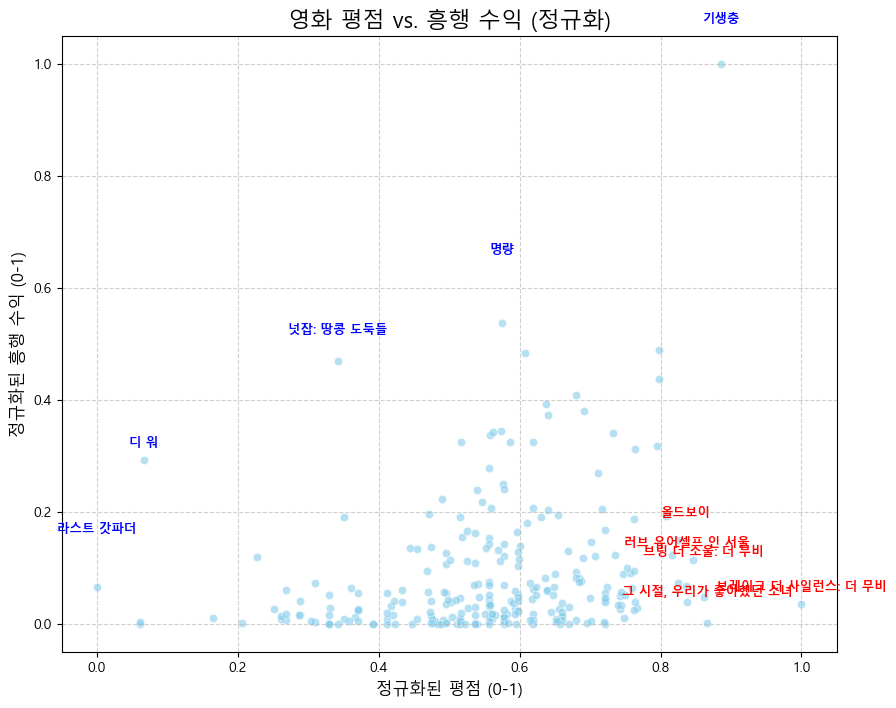

<Figure size 1200x600 with 0 Axes>

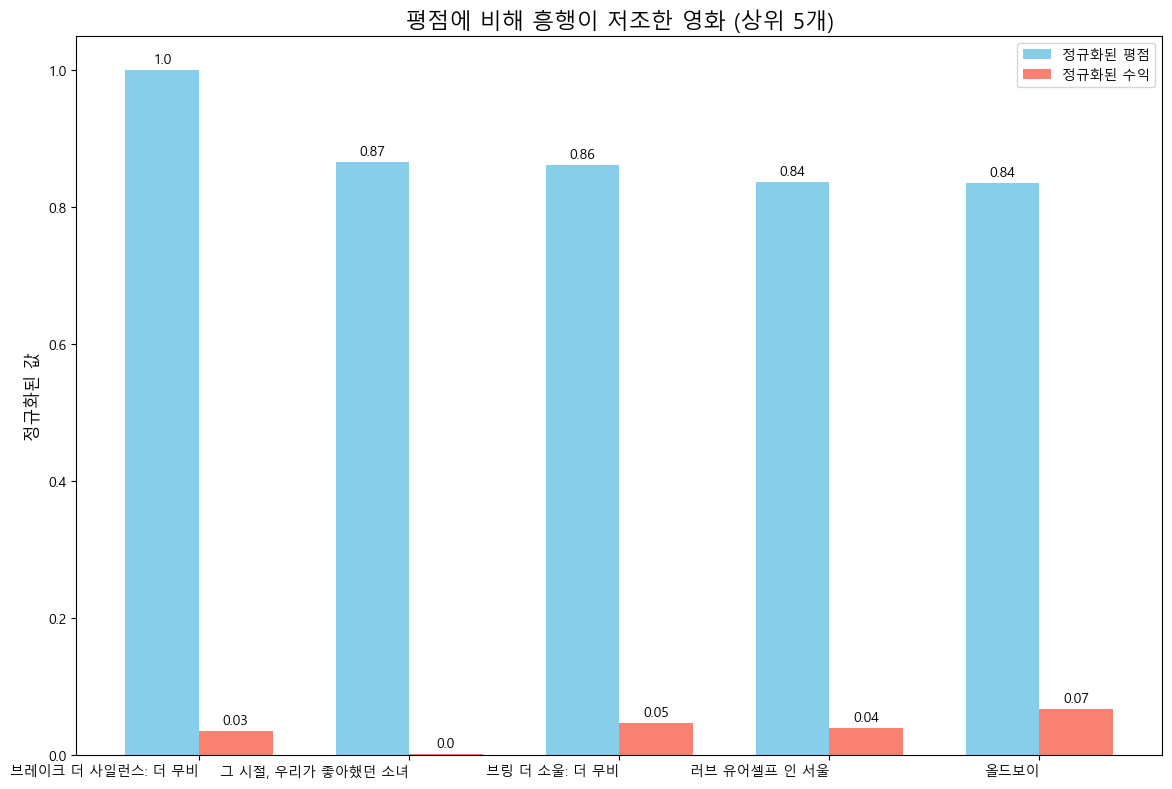

<Figure size 1200x600 with 0 Axes>

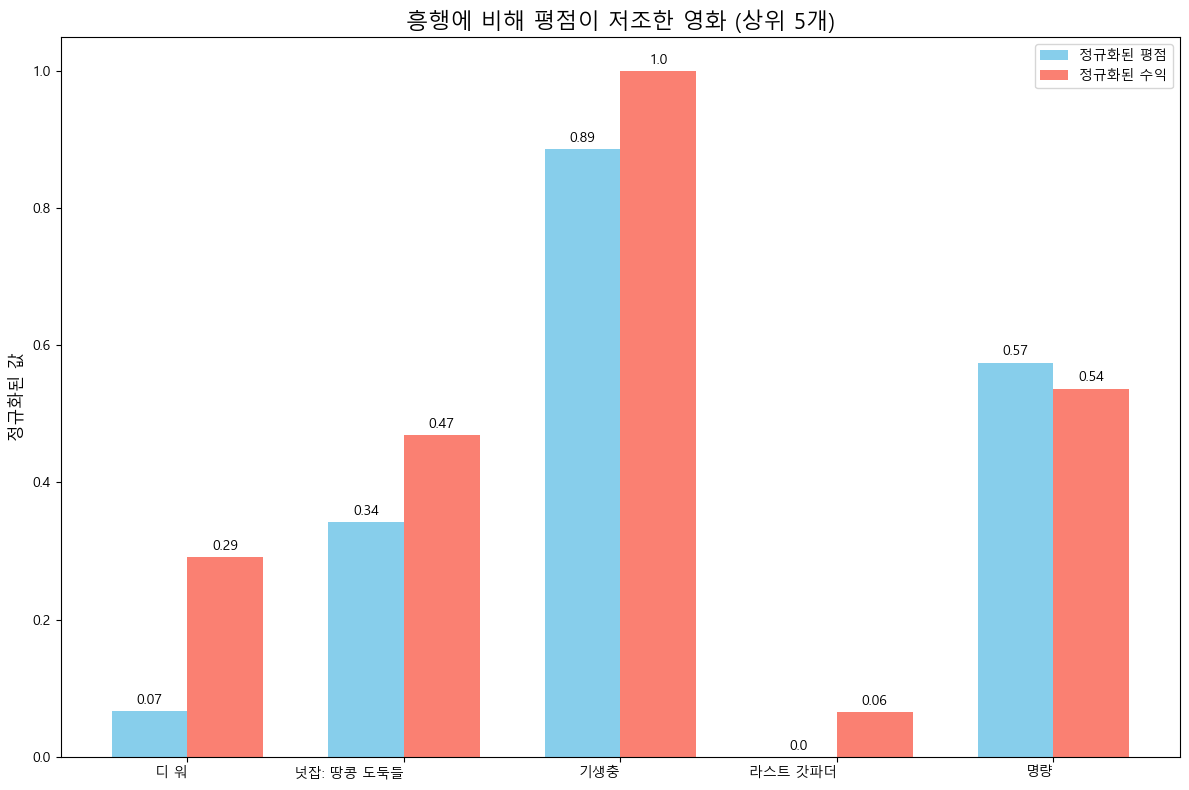

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

# matplotlib에서 한글 폰트가 깨지는 문제를 해결합니다.
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print(">>> 영화 평점과 흥행 수익 관계에 대한 시각화를 시작합니다.")

# 1. 파일 불러오기
file_path = 'tmdb_kr_theatrical_2005_2025.csv'
try:
    df = pd.read_csv(file_path)
    print(f"'{file_path}' 파일을 성공적으로 불러왔습니다.")
except FileNotFoundError:
    print(f"오류: '{file_path}' 파일을 찾을 수 없습니다. 파일 경로를 확인해 주세요.")
    exit()

# 2. 데이터 정제 및 필터링
# 수익이 있고, 투표 수가 10개 이상이며, 평점이 0보다 큰 영화만 필터링합니다.
df_filtered = df[(df['revenue'] > 0) & (df['vote_count'] >= 10) & (df['vote_average'] > 0)].copy()
print(f"분석을 위해 수익이 있고 투표 수가 10개 이상이며 평점이 0보다 큰 {len(df_filtered)}개의 영화를 필터링했습니다.")

# 3. 데이터 정규화 (MinMaxScaler 직접 구현)
def min_max_normalize(series):
    return (series - series.min()) / (series.max() - series.min())

df_filtered['normalized_vote_average'] = min_max_normalize(df_filtered['vote_average'])
df_filtered['normalized_revenue'] = min_max_normalize(df_filtered['revenue'])

# 4. 특이 사례 분석을 위한 새로운 지표 계산
df_filtered['rating_minus_revenue'] = df_filtered['normalized_vote_average'] - df_filtered['normalized_revenue']
df_filtered['revenue_minus_rating'] = df_filtered['normalized_revenue'] - df_filtered['normalized_vote_average']

# 5. 시각화 시작

# 5-1. 평점과 흥행 수익의 관계를 나타내는 산점도
plt.figure(figsize=(10, 8))
plt.scatter(df_filtered['normalized_vote_average'], df_filtered['normalized_revenue'], alpha=0.6, color='skyblue', edgecolors='w', linewidths=0.5)
plt.title('영화 평점 vs. 흥행 수익 (정규화)', fontsize=16)
plt.xlabel('정규화된 평점 (0-1)', fontsize=12)
plt.ylabel('정규화된 흥행 수익 (0-1)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# 평점에 비해 수익이 저조한 영화 (상위 5개)
high_rating_low_revenue_movies = df_filtered.sort_values(by='rating_minus_revenue', ascending=False).head(5)
# 텍스트 위치 겹침 방지를 위해 offset을 추가합니다.
offset = 10
for i, row in high_rating_low_revenue_movies.iterrows():
    plt.annotate(row['title'], (row['normalized_vote_average'], row['normalized_revenue']), 
                 textcoords="offset points", xytext=(0, offset), ha='center',
                 color='red', fontweight='bold', fontsize=9)
    offset += 10 # 텍스트가 겹치지 않도록 y축 offset을 증가시킵니다.

# 수익에 비해 평점이 저조한 영화 (상위 5개)
low_rating_high_revenue_movies = df_filtered.sort_values(by='revenue_minus_rating', ascending=False).head(5)
# 텍스트 위치 겹침 방지를 위해 offset을 추가합니다.
offset = 10
for i, row in low_rating_high_revenue_movies.iterrows():
    plt.annotate(row['title'], (row['normalized_vote_average'], row['normalized_revenue']), 
                 textcoords="offset points", xytext=(0, offset), ha='center',
                 color='blue', fontweight='bold', fontsize=9)
    offset += 10 # 텍스트가 겹치지 않도록 y축 offset을 증가시킵니다.

plt.show()

# 5-2. 평점에 비해 흥행이 저조한 영화 시각화
plt.figure(figsize=(12, 6))
# 막대 그래프를 그립니다. x축은 영화 제목, y축은 'normalized_vote_average'와 'normalized_revenue'
x = np.arange(len(high_rating_low_revenue_movies))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, high_rating_low_revenue_movies['normalized_vote_average'], width, label='정규화된 평점', color='skyblue')
rects2 = ax.bar(x + width/2, high_rating_low_revenue_movies['normalized_revenue'], width, label='정규화된 수익', color='salmon')

# 막대 위에 값 추가
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, ax)
autolabel(rects2, ax)

ax.set_title('평점에 비해 흥행이 저조한 영화 (상위 5개)', fontsize=16)
ax.set_ylabel('정규화된 값', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(high_rating_low_revenue_movies['title'], rotation=0, ha='right', fontsize=10)
ax.legend()
plt.tight_layout()
plt.show()

# 5-3. 흥행에 비해 평점이 저조한 영화 시각화
plt.figure(figsize=(12, 6))

x = np.arange(len(low_rating_high_revenue_movies))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x - width/2, low_rating_high_revenue_movies['normalized_vote_average'], width, label='정규화된 평점', color='skyblue')
rects2 = ax.bar(x + width/2, low_rating_high_revenue_movies['normalized_revenue'], width, label='정규화된 수익', color='salmon')

# 막대 위에 값 추가
autolabel(rects1, ax)
autolabel(rects2, ax)

ax.set_title('흥행에 비해 평점이 저조한 영화 (상위 5개)', fontsize=16)
ax.set_ylabel('정규화된 값', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(low_rating_high_revenue_movies['title'], rotation=0, ha='right', fontsize=10)
ax.legend()
plt.tight_layout()
plt.show()


### 영화 평점과 흥행 수익 상관관계 분석 보고서
#### 서론

본 보고서는 2005년부터 2025년까지의 한국 영화 데이터를 바탕으로 사용자 평점(vote_average)과 박스오피스 수익(revenue) 간의 상관관계를 분석하고, 평점과 흥행 간의 불일치가 나타나는 영화들의 특성을 심층적으로 탐구한다. 특히, 높은 평점을 받았지만 흥행에 실패한 영화와 평점은 낮지만 흥행에 성공한 영화의 공통점 및 차이점을 비교함으로써 영화 산업의 흥행 요인에 대한 이해를 넓히고자 한다.

1. 영화 평점 vs. 흥행 수익 산점도 분석
첫 번째 그래프는 정규화된 평점과 흥행 수익 간의 관계를 시각적으로 보여줍니다. 각 점은 하나의 영화를 나타냅니다.

《기생충》: 평점(약 0.9)과 흥행 수익(약 1.0) 모두 압도적으로 높아, 작품성과 대중성 모두를 성공적으로 확보한 사례로 나타납니다.

높은 평점, 낮은 흥행: 오른쪽 하단에 위치한 영화들(예: 《올드보이》)은 평점이 높지만 흥행 수익은 상대적으로 낮아, 비평가나 특정 팬층의 호평을 받았으나 대중적 인기로는 이어지지 않았음을 시사합니다.

데이터의 특징: 투표수를 10개 이상으로 제한했을 때, 평점이 매우 낮으면서 흥행에 크게 성공한 영화는 거의 나타나지 않았습니다. 이는 신뢰할 만한 대중의 평가에서는 평점과 흥행이 어느 정도 비례함을 보여줍니다.

2. 평점에 비해 흥행이 저조한 영화 (상위 5개)
두 번째 막대 그래프는 평점에 비해 흥행 수익이 낮은 영화들을 보여줍니다. 이는 '작품성은 높으나 흥행에 실패한' 영화들로 해석할 수 있습니다.

주요 특징: 평점(파란색 막대)은 높게 나타나지만, 흥행 수익(주황색 막대)은 현저히 낮습니다. 특히 **《브레이크 더 사일런스 더 무비》**는 평점이 최고치(1.0)임에도 흥행 수익이 매우 낮아, 특정 팬덤의 높은 평가가 반영된 결과로 추정됩니다.

시사점: 작품의 완성도나 평론가 평점만으로는 흥행 성공을 보장할 수 없다는 점을 강조합니다.

3. 흥행에 비해 평점이 저조한 영화 (상위 5개)
세 번째 막대 그래프는 흥행 수익은 높지만 평점은 상대적으로 낮은 영화들을 보여줍니다. 이는 '흥행에는 성공했으나 평가가 엇갈리는' 영화들입니다.

주요 특징: 흥행 수익(주황색 막대)이 평점(파란색 막대)보다 높은 경우가 많습니다. **《디 워》**나 **《라스트 갓파더》**처럼 대규모 마케팅이나 대중의 호기심을 자극하여 흥행에 성공했지만, 작품성에 대한 평가는 높지 않았던 영화들이 여기에 속합니다.

**《기생충》의 위치: 이 그룹에 포함된 **《기생충》**은 평점과 흥행 수익 모두 높지만, 상대적으로 흥행 수익이 평점보다 더 압도적인 수치를 기록했음을 보여줍니다.

결론
투표수 10개 이상으로 필터링된 데이터 분석 결과, 영화의 작품성과 대중적 흥행은 반드시 일치하지 않는다는 것을 알 수 있습니다. 평점이 높더라도 흥행에 실패할 수 있으며, 반대로 흥행에 성공하더라도 평점이 낮을 수 있습니다. 하지만 극히 드물게 **《기생충》**과 같이 두 마리 토끼를 모두 잡는 영화도 존재함을 확인할 수 있습니다.